In [1]:
!pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import string

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import optuna

2023-06-19 09:42:18.447465: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 09:42:18.905686: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 09:42:18.941618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 09:42:22.932447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 3)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0., 1.0)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [22]:
X_train = pd.read_csv("../../raw_data/titles_train.csv")["Title"].astype(str)
y_train = pd.read_csv("../../raw_data/train_y.csv", delimiter=" ", index_col="Id")['Genre_id']
X_test = pd.read_csv("../../raw_data/test_x.csv", delimiter=" ", index_col="Id")["Title"]
y_test = pd.read_csv("../../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']

In [7]:
#load for colab
from google.colab import drive
drive.mount('/content/drive')

X_train = pd.read_csv("/content/drive/My Drive/Wagon-Book-Cover/train_x.csv", delimiter=" ", index_col="Id")["Title"]
X_test = pd.read_csv("/content/drive/My Drive/Wagon-Book-Cover/test_x.csv", delimiter=" ", index_col="Id")["Title"]

train_file_path = '/content/drive/My Drive/Wagon-Book-Cover/y_train_umbr.npy'
test_file_path = '/content/drive/My Drive/Wagon-Book-Cover/y_test_umbr.npy'
y_train_um = np.load(train_file_path, allow_pickle=True)
y_test_um = np.load(test_file_path, allow_pickle=True)
genre_dict = pd.DataFrame(y_train_um).set_index(0)[1].to_dict()
genre_dict_um = pd.DataFrame(y_train_um).set_index(3)[2].to_dict()
y_train_um = np.load(train_file_path, allow_pickle=True)[:, 3].astype(int)
y_test_um = np.load(test_file_path, allow_pickle=True)[:, 3].astype(int)
y_train = np.load(train_file_path, allow_pickle=True)[:, 0].astype(int)
y_test = np.load(test_file_path, allow_pickle=True)[:, 0].astype(int)

ModuleNotFoundError: No module named 'google.colab'

In [23]:
X_train

0        Colet example, and SA sported ronals Gentl Twi...
1                   Maghets Pulling Together Pushing Apart
2        ENERGY SECURITY VOLUME SAGE LIBRARY OF INTERNA...
3        AUDIOBOOK MP3-CD Insert Transfer Listen! TREES...
4             City of Rocks Idaho A Climber's Guide untale
                               ...                        
51295    JOHN SANDFORD NEW YORK TIMES-BESTSELLING AUTHO...
51296    SECOND EDITION THE CRIME WRITER'S GUIDE TO POL...
51297               THE JEZEBEL REMEDY A Nord MARTIN CLARK
51298                                  STARTUP GLENN OGURA
51299    Bad karaden The Mystery Mystery Ender KILLER T...
Name: Title, Length: 51300, dtype: object

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

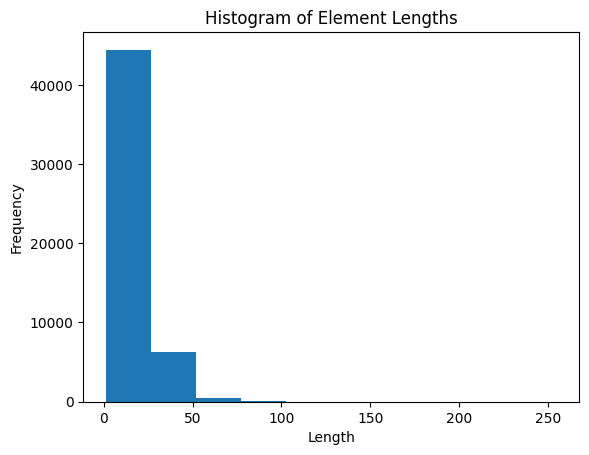

In [25]:
lengths = []
for element in X_train_token:
    lengths.append(len(element))

plt.hist(lengths, bins=10)  # Adjust the number of bins as needed
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Element Lengths')
plt.show()

In [26]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', value=0, maxlen=60)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', value=0, maxlen=60)
X_train_pad

array([[2.42130e+04, 6.51000e+03, 2.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.71030e+04, 3.71040e+04, 1.43500e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.68000e+02, 6.66000e+02, 9.20000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.00000e+00, 3.26890e+04, 9.51100e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.45300e+03, 1.80200e+03, 1.14027e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [7.57000e+02, 1.14028e+05, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]], dtype=float32)

In [27]:
y_train_cat = to_categorical(y_train, num_classes=30)
y_test_cat = to_categorical(y_test, num_classes=30)
y_train_cat.shape

(51300, 30)

In [28]:
vocab_size = len(tokenizer.word_counts)
vocab_size

114031

In [31]:
def initialize_model():
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1, # 16 +1 for the 0 padding
        output_dim=20,
        input_length=60,
        mask_zero=True, # Built-in masking layer :)
    ))

    model.add(layers.Conv1D(30, kernel_size=3))

    model.add(layers.Flatten())

    model.add(layers.Dense(30, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return model

In [32]:
model_cnn = initialize_model()

es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")

history = model_cnn.fit(X_train_pad, y_train_cat,
              epochs=1000,
              batch_size=16,
              validation_split=0.3,
              callbacks=[es]
             )


res = model_cnn.evaluate(X_test_pad, y_test_cat, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Epoch 1/1000
2245/2245 [==============================] - 18s 7ms/step - loss: 2.9182 - accuracy: 0.1740 - val_loss: 3.1396 - val_accuracy: 0.1238
Epoch 2/1000
2245/2245 [==============================] - 15s 7ms/step - loss: 2.2550 - accuracy: 0.3722 - val_loss: 2.9516 - val_accuracy: 0.1813
Epoch 3/1000
2245/2245 [==============================] - 14s 6ms/step - loss: 1.8767 - accuracy: 0.4876 - val_loss: 2.8489 - val_accuracy: 0.2238
Epoch 4/1000
2245/2245 [==============================] - 15s 7ms/step - loss: 1.5911 - accuracy: 0.5774 - val_loss: 2.7223 - val_accuracy: 0.2765
Epoch 5/1000
2245/2245 [==============================] - 14s 6ms/step - loss: 1.3488 - accuracy: 0.6465 - val_loss: 2.9025 - val_accuracy: 0.2755
Epoch 6/1000
2245/2245 [==============================] - 15s 7ms/step - loss: 1.1410 - accuracy: 0.7073 - val_loss: 2.9590 - val_accuracy: 0.2888
Epoch 7/1000
2245/2245 [==============================] - 15s 7ms/step - loss: 0.9594 - accuracy: 0.7552 - val_loss: 2

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

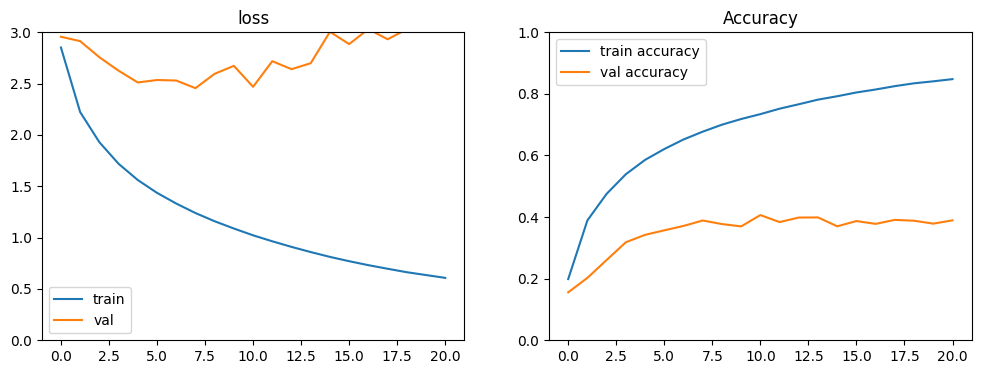

In [ ]:
plot_history(history)

In [ ]:
y_pred = np.argmax(model_cnn.predict(X_test_pad), axis=1)

/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-14 17:43:15.732702: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_28/Softmax' id:32925 op device:{requested: '', assigned: ''} def:{{{node dense_28/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_28/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


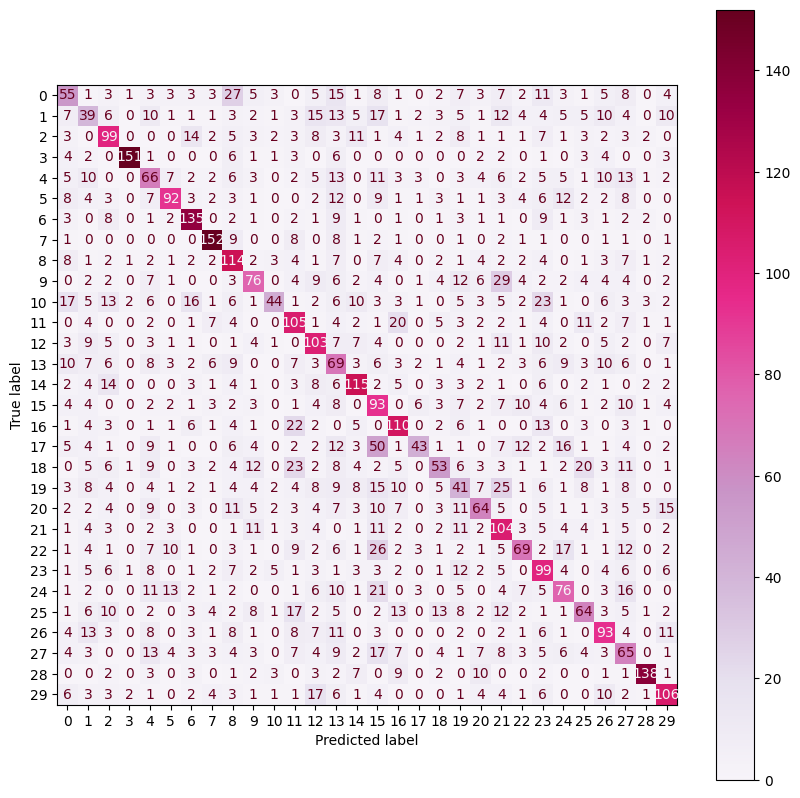

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

## Test umbrella category

In [36]:
train_file_path = '../../raw_data/tmp_data/y_train_umbr.npy'
test_file_path = '../../raw_data/tmp_data/y_test_umbr.npy'
y_train_um = np.load(train_file_path, allow_pickle=True)
y_test_um = np.load(test_file_path, allow_pickle=True)
genre_dict = pd.DataFrame(y_train_um).set_index(3)[2].to_dict()

In [37]:
y_train_um = np.load(train_file_path, allow_pickle=True)[:, 3].astype(int)
y_test_um = np.load(test_file_path, allow_pickle=True)[:, 3].astype(int)

In [38]:
y_train_um

array([0, 1, 2, ..., 4, 4, 4])

In [39]:
y_train_um_cat = to_categorical(y_train_um, num_classes=8)
y_test_um_cat = to_categorical(y_test_um, num_classes=8)
y_train_cat.shape

(51300, 30)

In [42]:
def initialize_model():
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1, # 16 +1 for the 0 padding
        output_dim=20,
        input_length=60,
        mask_zero=True, # Built-in masking layer :)
    ))

    model.add(layers.Conv1D(30, kernel_size=3))

    model.add(layers.Flatten())

    model.add(layers.Dense(8, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return model

In [ ]:
model_cnn = initialize_model()

es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")

history = model_cnn.fit(X_train_pad, y_train_um_cat,
              epochs=1000,
              batch_size=16,
              validation_split=0.3,
              callbacks=[es]
             )


res = model_cnn.evaluate(X_test_pad, y_test_um_cat, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Epoch 1/1000
2245/2245 [==============================] - 20s 9ms/step - loss: 1.6067 - accuracy: 0.4089 - val_loss: 1.5691 - val_accuracy: 0.4589
Epoch 2/1000
2245/2245 [==============================] - 16s 7ms/step - loss: 1.1690 - accuracy: 0.6118 - val_loss: 1.4842 - val_accuracy: 0.5134
Epoch 3/1000
2245/2245 [==============================] - 16s 7ms/step - loss: 0.9635 - accuracy: 0.6943 - val_loss: 1.4910 - val_accuracy: 0.5399
Epoch 4/1000
2245/2245 [==============================] - 16s 7ms/step - loss: 0.8139 - accuracy: 0.7496 - val_loss: 1.5217 - val_accuracy: 0.5305
Epoch 5/1000
2245/2245 [==============================] - 16s 7ms/step - loss: 0.6902 - accuracy: 0.7901 - val_loss: 1.6059 - val_accuracy: 0.5405
Epoch 6/1000
2245/2245 [==============================] - 14s 6ms/step - loss: 0.5821 - accuracy: 0.8292 - val_loss: 1.6226 - val_accuracy: 0.5438
Epoch 7/1000
2245/2245 [==============================] - 15s 7ms/step - loss: 0.4843 - accuracy: 0.8590 - val_loss: 1

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

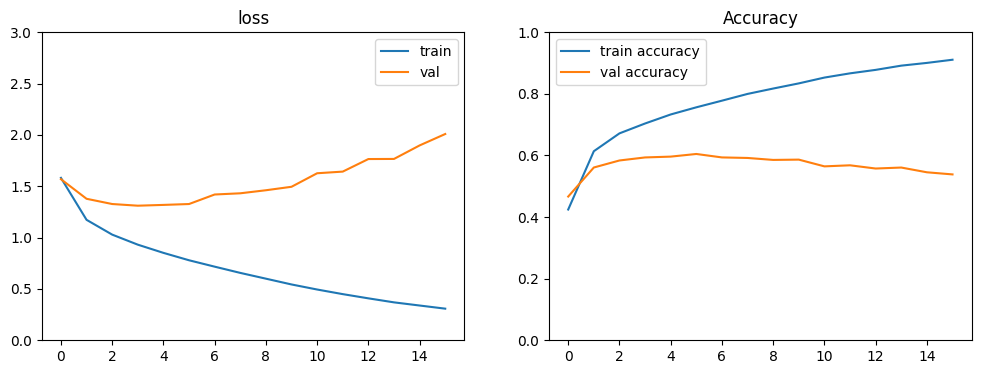

In [ ]:
plot_history(history)

In [ ]:
y_pred = np.argmax(model_cnn.predict(X_test_pad), axis=1)

179/179 [==============================] - 0s 1ms/step


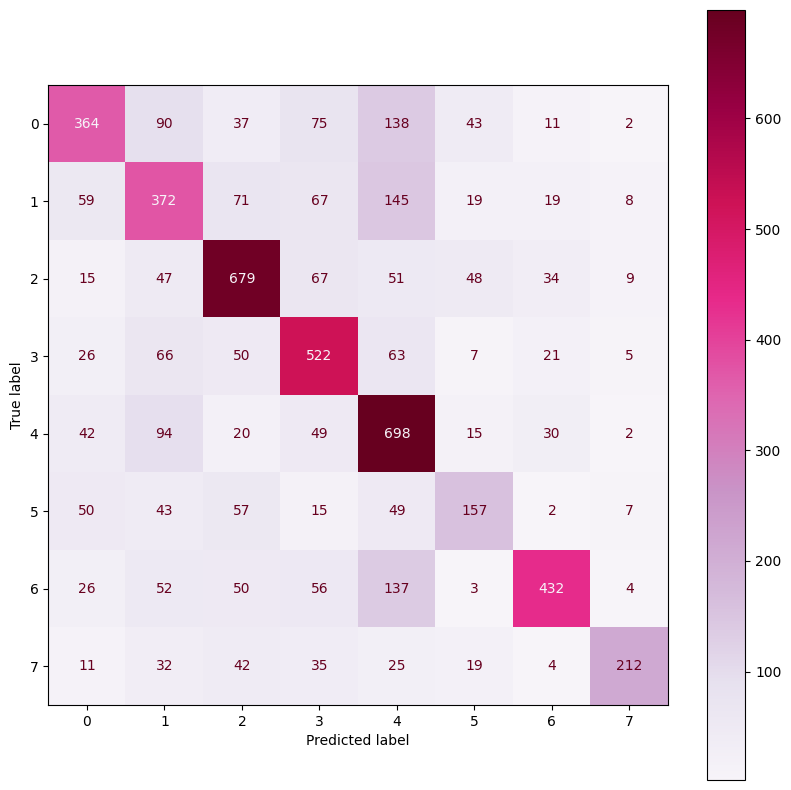

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_um, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

In [ ]:
genre_dict

{0: 'History & Religion',
 1: 'Relationships & Children',
 2: 'Academic - Science',
 3: 'Lifestyle & Fitness',
 5: 'Academic - Humanities',
 6: 'Arts & Hobbies',
 4: 'Literature & Entertainment',
 7: 'Academic - Pure'}

## Transfer learning tests

In [ ]:
!pip install transformers
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.4 MB/s eta 0:00:00


In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
X_train_tf = np.array([tokenizer(text, padding='max_length', max_length = 40, truncation=True)['input_ids'] for text in X_train])
X_test_tf = np.array([tokenizer(text, padding='max_length', max_length = 40, truncation=True)['input_ids'] for text in X_test])

In [ ]:
print('Shape of training data: ',X_train_tf.shape)
print('Shape of test data: ',X_test_tf.shape)

Shape of training data:  (51300, 40)
Shape of test data:  (5700, 40)


In [ ]:
# Get BERT layer
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert_tf = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
from tensorflow.keras import models, layers, metrics

input_ids_in = layers.Input(shape=(40,), name='input_token', dtype='int32')

x = dbert_tf(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
x = layers.Dense(30, activation='softmax', name='classification')(x)

model_tf = models.Model(inputs=input_ids_in, outputs = x, name='ClassificationModelTF')

model_tf.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=[metrics.SparseCategoricalAccuracy()])
model_tf.summary()

Model: "ClassificationModelTF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 40)]              0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 40, 7            
                             68),                                
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_1   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                             

In [ ]:
from datetime import datetime

es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_sparse_categorical_accuracy")

# Train the model
start_time = datetime.now()
history = model_tf.fit(X_train_tf,
                       y_train,
                       batch_size=64,
                       shuffle=True,
                       epochs=100,
                       validation_split=0.3,
                       callbacks=[es])
end_time = datetime.now()

training_time_tf = (end_time - start_time).total_seconds()

Epoch 1/100
562/562 [==============================] - 96s 170ms/step - loss: 2.0629 - sparse_categorical_accuracy: 0.4170 - val_loss: 2.3060 - val_sparse_categorical_accuracy: 0.3404
Epoch 2/100
562/562 [==============================] - 75s 133ms/step - loss: 2.0355 - sparse_categorical_accuracy: 0.4214 - val_loss: 2.2207 - val_sparse_categorical_accuracy: 0.3572
Epoch 3/100
562/562 [==============================] - 94s 167ms/step - loss: 2.0205 - sparse_categorical_accuracy: 0.4275 - val_loss: 2.2472 - val_sparse_categorical_accuracy: 0.3600
Epoch 4/100
562/562 [==============================] - 94s 167ms/step - loss: 2.0088 - sparse_categorical_accuracy: 0.4293 - val_loss: 2.2714 - val_sparse_categorical_accuracy: 0.3589
Epoch 5/100
562/562 [==============================] - 94s 168ms/step - loss: 2.0053 - sparse_categorical_accuracy: 0.4304 - val_loss: 2.1433 - val_sparse_categorical_accuracy: 0.3864
Epoch 6/100
562/562 [==============================] - 94s 167ms/step - loss: 2.

KeyError: ignored

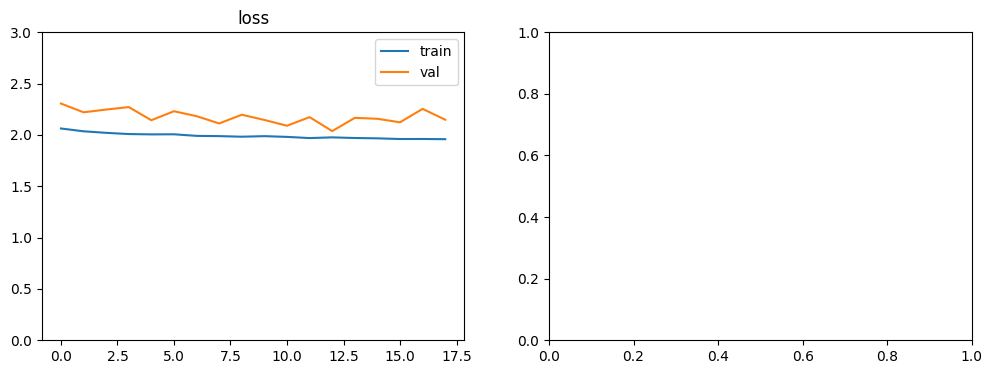

In [ ]:
plot_history(history)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

NameError: ignored

In [ ]:
from tensorflow.keras import models, layers, metrics

input_ids_in = layers.Input(shape=(40,), name='input_token', dtype='int32')

x = dbert_tf(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
x = layers.Dense(8, activation='softmax', name='classification')(x)

model_tf = models.Model(inputs=input_ids_in, outputs = x, name='ClassificationModelTF')

model_tf.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=[metrics.SparseCategoricalAccuracy()])
model_tf.summary()

Model: "ClassificationModelTF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 40)]              0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 40, 7            
                             68),                                
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_3   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                             

In [ ]:
from datetime import datetime

es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_sparse_categorical_accuracy")

# Train the model
start_time = datetime.now()
history = model_tf.fit(X_train_tf,
                       y_train_um,
                       batch_size=64,
                       shuffle=True,
                       epochs=100,
                       validation_split=0.3,
                       callbacks=[es])
end_time = datetime.now()

training_time_tf = (end_time - start_time).total_seconds()

Epoch 1/100
562/562 [==============================] - 80s 128ms/step - loss: 1.5165 - sparse_categorical_accuracy: 0.4591 - val_loss: 1.5003 - val_sparse_categorical_accuracy: 0.5027
Epoch 2/100
562/562 [==============================] - 73s 131ms/step - loss: 1.3663 - sparse_categorical_accuracy: 0.5180 - val_loss: 1.5009 - val_sparse_categorical_accuracy: 0.4912
Epoch 3/100
562/562 [==============================] - 93s 166ms/step - loss: 1.3383 - sparse_categorical_accuracy: 0.5276 - val_loss: 1.5017 - val_sparse_categorical_accuracy: 0.4933
Epoch 4/100
562/562 [==============================] - 74s 131ms/step - loss: 1.3248 - sparse_categorical_accuracy: 0.5320 - val_loss: 1.3773 - val_sparse_categorical_accuracy: 0.5457
Epoch 5/100
562/562 [==============================] - 93s 166ms/step - loss: 1.3146 - sparse_categorical_accuracy: 0.5365 - val_loss: 1.3831 - val_sparse_categorical_accuracy: 0.5285
Epoch 6/100
562/562 [==============================] - 94s 168ms/step - loss: 1.

# Search space using optuna

In [ ]:
def create_model(trial):
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=trial.suggest_int("embedding_units", 10, 50),
        input_length=40,
        mask_zero=True,
    ))

    model.add(layers.Conv1D(trial.suggest_int("conv_units", 10, 50), kernel_size=trial.suggest_int("kernel_size", 3, 5)))

    model.add(layers.Flatten())

    model.add(layers.Dense(30, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return model

def objective(trial):
    model = create_model(trial)
    es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")
    history = model.fit(X_train_pad, y_train_cat,
                        epochs=1000,
                        batch_size=32,
                        validation_split=0.3,
                        callbacks=[es],
                        verbose=0)
    return history.history["val_accuracy"][-1]

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2023-06-14 17:43:20,081] A new study created in memory with name: no-name-a2a85dc5-75cc-4dcc-a5b4-27faf13b5d0c
2023-06-14 17:43:25.536910: W tensorflow/c/c_api.cc:300] Operation '{name:'training/RMSprop/dense/bias/rms/Assign' id:284 op device:{requested: '', assigned: ''} def:{{{node training/RMSprop/dense/bias/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/RMSprop/dense/bias/rms, training/RMSprop/dense/bias/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-14 17:43:25.615699: W tensorflow/c/c_api.cc:300] Operation '{name:'training/RMSprop/dense/kernel/rms/Assign' id:279 op device:{requested: '', assigned: ''} def:{{{node training/RMSprop/dense/kernel/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, d

2023-06-14 17:43:50.766588: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:152 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-14 17:43:50.976838: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:152 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-14 17:43:51.128482: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/

KeyboardInterrupt: 